In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats import uniform, loguniform
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression, BayesianRidge, Ridge, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import warnings
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('max_columns', None)

In [2]:
# read files
df_train = pd.read_csv('input/train.csv')
df_train['Train/Test'] = np.zeros(len(df_train.index))
df_test = pd.read_csv('input/test.csv')
df_test['Train/Test'] = np.ones(len(df_test.index))

# 1. Preprocessing

We will follow the guidelines stablish in the EDA script. Exactly the same transformations/imputations/deletions explained there are performed here.

In [3]:
# Create array to transform
to_box_cox = []
to_yeoj = []

## 1.1 Target

In [4]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

## 1.2 MSZoning

In [5]:
df_full = pd.concat([df_train, df_test]).reset_index(drop=True)
df_full['MSZoning'] = df_full.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
df_train = df_full[df_full['Train/Test']==0].reset_index(drop=True)
df_test = df_full[df_full['Train/Test']==1].reset_index(drop=True)

## 1.3 MSSubClass

In [6]:
df_full = pd.concat([df_train, df_test]).reset_index(drop=True)
df_full = df_full.replace({'MSSubClass':150}, df_full.groupby('MSZoning')['MSSubClass'].median()['RL'])
df_train = df_full[df_full['Train/Test']==0].reset_index(drop=True)
df_test = df_full[df_full['Train/Test']==1].reset_index(drop=True)

df_train = pd.get_dummies(df_train, columns=['MSZoning','MSSubClass'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['MSZoning','MSSubClass'], drop_first=True)

## 1.4 LotFrontage

In [7]:
df_train = df_train.drop([934, 1298], axis=0)
df_full = pd.concat([df_train, df_test]).reset_index(drop=True)
df_full["LotFrontage"] = df_full.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df_train = df_full[df_full['Train/Test']==0].reset_index(drop=True)
df_test = df_full[df_full['Train/Test']==1].reset_index(drop=True)

## 1.5 LotArea

In [8]:
df_train['LotArea'] = df_train['LotArea'].apply(lambda x: 100000 if x > 100000 else x)
df_train['LotArea'] = np.log(df_train['LotArea'])
df_test['LotArea'] = np.log(df_test['LotArea'])

## 1.6 Alley

In [9]:
df_train['Alley'] = df_train['Alley'].fillna("NoAlley")
df_test['Alley'] = df_test['Alley'].fillna("NoAlley")

df_train = pd.get_dummies(df_train, columns=['Alley'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Alley'], drop_first=True)

## 1.7 LotShape

In [10]:
df_train = pd.get_dummies(df_train, columns=['LotShape'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['LotShape'], drop_first=True)

## 1.8 LandContour

In [11]:
df_train = pd.get_dummies(df_train, columns=['LandContour'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['LandContour'], drop_first=True)

## 1.9 Utilities

In [12]:
df_train = df_train.drop(['Utilities'], axis=1)
df_test = df_test.drop(['Utilities'], axis=1)

## 1.10 LotConfig

In [13]:
df_train = pd.get_dummies(df_train, columns=['LotConfig'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['LotConfig'], drop_first=True)

## 1.11 LandSlope

In [14]:
df_train['LandSlope'] = df_train['LandSlope'].apply(lambda x:'Mod' if x in ['Mod', 'Sev'] else 'Gtl')
df_test['LandSlope'] = df_test['LandSlope'].apply(lambda x:'Mod' if x in ['Mod', 'Sev'] else 'Gtl')

df_train = pd.get_dummies(df_train, columns=['LandSlope'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['LandSlope'], drop_first=True)

## 1.12 Neighborhood

In [15]:
def neighborhood_loc(df):
    df["North"] = df["Neighborhood"].apply(lambda x: 1 if x in ["Blmngtn", "BrDale", "ClearCr", "Gilbert",  "Names", "NoRidge", 
                                                                  "NPkVill", "NWAmes", "NoRidge", "NridgHt", "Sawyer", "Somerst", 
                                                                  "StoneBr", "Veenker", "NridgHt"] else 0)

    df["South"] = df["Neighborhood"].apply(lambda x: 1 if x in ["Blueste", "Edwards", "Mitchel", "MeadowV", 
                                                                  "SWISU", "IDOTRR", "Timber"] else 0)

    df["Downtown"] = df["Neighborhood"].apply(lambda x: 1 if x in ["BrkSide", "Crawfor", "OldTown", "CollgCr"] else 0)

    df["East"] = df["Neighborhood"].apply(lambda x: 1 if x in ["IDOTRR", "Mitchel"] else 0)

    df["West"] = df["Neighborhood"].apply(lambda x: 1 if x in ["Edwards", "NWAmes", "SWISU", "Sawyer", "SawyerW"] else 0)
    
    df = df.drop(['Neighborhood'], axis=1)
    
    return df

df_train = neighborhood_loc(df_train)
df_test = neighborhood_loc(df_test)

## 1.13 Condition1

In [16]:
df_train['Condition1'] = df_train['Condition1'].apply(lambda x:'RRNe' if x in ['RRAe']
                                                     else ('PosN' if x in ['PosA'] 
                                                        else ('RRNn' if x in ['RRAn'] else x)
                                                          ))
df_test['Condition1'] = df_test['Condition1'].apply(lambda x:'RRNe' if x in ['RRAe']
                                                     else ('PosN' if x in ['PosA'] 
                                                        else ('RRNn' if x in ['RRAn'] else x)
                                                          ))

df_train = pd.get_dummies(df_train, columns=['Condition1'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Condition1'], drop_first=True)

## 1.14 Condition2

In [17]:
df_train = pd.get_dummies(df_train, columns=['Condition2'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Condition2'], drop_first=True)

df_train = df_train.drop(['Condition2_RRAn', 'Condition2_RRNn', 'Condition2_RRAe'], axis=1)

## 1.15 BldgType

In [18]:
df_train = pd.get_dummies(df_train, columns=['BldgType'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['BldgType'], drop_first=True)

## 1.16 HouseStyle

In [19]:
df_train = pd.get_dummies(df_train, columns=['HouseStyle'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['HouseStyle'], drop_first=True)

df_train = df_train.drop(['HouseStyle_2.5Fin'], axis=1)

## 1.17 OverallQual

We need it for the 'MasVnrArea' feat, so we will get dummies later.

## 1.18 OverallCond

In [20]:
df_train['Total_Home_Quality'] = df_train['OverallQual'] + df_train['OverallCond']
df_test['Total_Home_Quality'] = df_test['OverallQual'] + df_test['OverallCond']

df_train = pd.get_dummies(df_train, columns=['Total_Home_Quality'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Total_Home_Quality'], drop_first=True)

df_train = df_train.drop(['OverallCond'], axis=1)
df_test = df_test.drop(['OverallCond'], axis=1)

## 1.19 YearRemodAdd

In [21]:
def has_restoration(df):
    df["RestorationAge"] = df["YearRemodAdd"] - df["YearBuilt"]
    df["HasRestoration"] = df["RestorationAge"].apply(lambda x: 0 if x == 0 else 1)
    df = df.drop(['RestorationAge', 'YearRemodAdd'], axis=1)
    return df

df_train = has_restoration(df_train)
df_test = has_restoration(df_test)

## 1.20 YearBuilt

In [22]:
df_train['YearBuilt'] = df_train['YearBuilt'].apply(lambda x: 0 if x<1980 else 1)

## 1.21 RoofStyle

In [23]:
df_train = pd.get_dummies(df_train, columns=['RoofStyle'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['RoofStyle'], drop_first=True)

## 1.22 RoofMatl

In [24]:
df_train = pd.get_dummies(df_train, columns=['RoofMatl'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['RoofMatl'], drop_first=True)

df_train = df_train.drop(['RoofMatl_Metal','RoofMatl_Membran','RoofMatl_Roll'], axis=1)

## 1.23 Exterior1st

In [25]:
df_test['Exterior1st'].fillna('VinylSd', inplace=True)
df_train = pd.get_dummies(df_train, columns=['Exterior1st'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Exterior1st'], drop_first=True)

df_train = df_train.drop(['Exterior1st_Stone','Exterior1st_BrkComm','Exterior1st_ImStucc','Exterior1st_CBlock','Exterior1st_AsphShn'], axis=1)
df_test = df_test.drop(['Exterior1st_BrkComm','Exterior1st_CBlock','Exterior1st_AsphShn'], axis=1)

## 1.24 Exterior2nd

In [26]:
df_test['Exterior2nd'].fillna('VinylSd', inplace=True)
df_train = pd.get_dummies(df_train, columns=['Exterior2nd'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Exterior2nd'], drop_first=True)

df_train = df_train.drop(['Exterior2nd_Stone','Exterior2nd_Brk Cmn','Exterior2nd_CBlock','Exterior2nd_AsphShn','Exterior2nd_Other'], axis=1)
df_test = df_test.drop(['Exterior2nd_Stone','Exterior2nd_Brk Cmn','Exterior2nd_CBlock','Exterior2nd_AsphShn'], axis=1)

## 1.25 MasVnrType

In [27]:
df_train = df_train.drop(['MasVnrType'], axis=1)
df_test = df_test.drop(['MasVnrType'], axis=1)

## 1.26 MasVnrArea

In [28]:
df_full = pd.concat([df_train, df_test]).reset_index(drop=True)
df_full["MasVnrArea"] = df_full.groupby("OverallQual")["MasVnrArea"].apply(lambda x: x.fillna(x.median()))
df_train = df_full[df_full['Train/Test']==0].reset_index(drop=True)
df_test = df_full[df_full['Train/Test']==1].reset_index(drop=True)

df_train = pd.get_dummies(df_train, columns=['OverallQual'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['OverallQual'], drop_first=True)

In [29]:
to_yeoj.append('MasVnrArea')

## 1.27 ExterQual

In [30]:
df_train = pd.get_dummies(df_train, columns=['ExterQual'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['ExterQual'], drop_first=True)

## 1.28 ExterCond

In [31]:
df_train['ExterCond'] = df_train['ExterCond'].apply(lambda x:'Fa' if x in ['Po', 'Fa'] else x)
df_train['ExterCond'] = df_train['ExterCond'].apply(lambda x:'Ex' if x in ['Ex', 'Gd'] else x)
df_test['ExterCond'] = df_test['ExterCond'].apply(lambda x:'Fa' if x in ['Po', 'Fa'] else x)
df_test['ExterCond'] = df_test['ExterCond'].apply(lambda x:'Ex' if x in ['Ex', 'Gd'] else x)

df_train = pd.get_dummies(df_train, columns=['ExterCond'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['ExterCond'], drop_first=True)

## 1.29 Foundation

In [32]:
df_train = pd.get_dummies(df_train, columns=['Foundation'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Foundation'], drop_first=True)

## 1.30 Basement features

In [33]:
def impute_bsmt_feat(df):
    mask = (df['TotalBsmtSF']==0)
    df.loc[df['BsmtQual'].isnull() & mask, 'BsmtQual'] = 'NoBsmt'
    df.loc[df['BsmtCond'].isnull() & mask, 'BsmtCond'] = 'NoBsmt'
    df.loc[df['BsmtExposure'].isnull() & mask, 'BsmtExposure'] = 'NoBsmt'

    df.loc[df['BsmtFinType1'].isnull() & (df['BsmtFinSF1']==0), 'BsmtFinType1'] = 'NoBsmt'
    df.loc[df['BsmtFinType2'].isnull() & (df['BsmtFinSF2']==0), 'BsmtFinType2'] = 'NoBsmt'
    
    df.loc[df['BsmtFinType1'].isnull() & (df['BsmtUnfSF']>0), 'BsmtFinType1'] = 'Unf'
    df.loc[df['BsmtFinType2'].isnull() & (df['BsmtUnfSF']>0), 'BsmtFinType2'] = 'Unf'
    return df

df_train = impute_bsmt_feat(df_train)
df_test = impute_bsmt_feat(df_test)

df_test["BsmtFinSF1"].fillna(df_train.groupby("1stFlrSF")["BsmtFinSF1"].median() , inplace=True)
df_test["BsmtFinSF2"].fillna(df_train.groupby("1stFlrSF")["BsmtFinSF2"].median() , inplace=True)
df_test["BsmtUnfSF"].fillna(df_train.groupby("1stFlrSF")["BsmtUnfSF"].median() , inplace=True)
df_test["TotalBsmtSF"].fillna(df_train.groupby("1stFlrSF")["TotalBsmtSF"].median() , inplace=True)

df_test["BsmtQual"].fillna(df_train["BsmtQual"].mode().iloc[0] , inplace=True)
df_test["BsmtCond"].fillna(df_train["BsmtCond"].mode().iloc[0] , inplace=True)
df_train["BsmtExposure"].fillna(df_train["BsmtExposure"].mode().iloc[0] , inplace=True)
df_test["BsmtExposure"].fillna(df_train["BsmtExposure"].mode().iloc[0] , inplace=True)
df_test["BsmtFinType1"].fillna(df_train["BsmtFinType1"].mode().iloc[0] , inplace=True)
df_test["BsmtFinType2"].fillna(df_train["BsmtFinType2"].mode().iloc[0] , inplace=True)

In [34]:
bsmt_feat = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
df_train = pd.get_dummies(df_train, columns=bsmt_feat, drop_first=True)
df_test = pd.get_dummies(df_test, columns=bsmt_feat, drop_first=True)

In [35]:
to_yeoj.append('BsmtFinSF1')
to_yeoj.append('BsmtFinSF2')
to_yeoj.append('BsmtUnfSF')
to_yeoj.append('TotalBsmtSF')

## 1.31 Heating

In [36]:
df_train = pd.get_dummies(df_train, columns=['Heating'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Heating'], drop_first=True)

df_train = df_train.drop(['Heating_OthW', 'Heating_GasA'], axis=1)

## 1.32 HeatingQC

In [37]:
df_train['HeatingQC'] = df_train['HeatingQC'].apply(lambda x:'Fa' if x in ['Po', 'Fa'] else x)
df_test['HeatingQC'] = df_test['HeatingQC'].apply(lambda x:'Fa' if x in ['Po', 'Fa'] else x)

df_train = pd.get_dummies(df_train, columns=['HeatingQC'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['HeatingQC'], drop_first=True)

## 1.33 CentralAir

In [38]:
df_train = pd.get_dummies(df_train, columns=['CentralAir'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['CentralAir'], drop_first=True)

## 1.34 Electrical

In [39]:
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train = df_train.drop(df_train.loc[df_train['Electrical']=='Mix'].index)

df_train = pd.get_dummies(df_train, columns=['Electrical'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Electrical'], drop_first=True)

## 1.35 1stFlrSF

In [40]:
to_box_cox.append('1stFlrSF')

## 1.36 2ndFlrSF

In [41]:
df_train['TotalFlrSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF']
df_test['TotalFlrSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [42]:
df_train['2ndFlr'] = df_train['2ndFlrSF'].apply(lambda x:'Y' if x > 0 else 'N')
df_test['2ndFlr'] = df_test['2ndFlrSF'].apply(lambda x:'Y' if x > 0 else 'N')

df_train = df_train.drop(['2ndFlrSF'], axis=1)
df_test = df_test.drop(['2ndFlrSF'], axis=1)

df_train = pd.get_dummies(df_train, columns=['2ndFlr'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['2ndFlr'], drop_first=True)

## 1.37 LowQualFinSF

In [43]:
df_train['LowQualFin'] = df_train['LowQualFinSF'].apply(lambda x:'Y' if x > 0 else 'N')
df_test['LowQualFin'] = df_test['LowQualFinSF'].apply(lambda x:'Y' if x > 0 else 'N')

df_train = df_train.drop(['LowQualFinSF'], axis=1)
df_test = df_test.drop(['LowQualFinSF'], axis=1)

df_train = pd.get_dummies(df_train, columns=['LowQualFin'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['LowQualFin'], drop_first=True)

## 1.38 GrLivArea

In [44]:
df_train = df_train.drop(df_train.loc[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index)
to_box_cox.append('GrLivArea')

In [45]:
df_train["TotalArea"] = df_train["TotalBsmtSF"] + df_train["GrLivArea"]
df_test["TotalArea"] = df_test["TotalBsmtSF"] + df_test["GrLivArea"]
to_box_cox.append('TotalArea')

## 1.39 BsmtFullBath

In [46]:
df_train['BsmtFullBath'] = df_train['BsmtFullBath'].apply(lambda x:2.0 if x in [2.0, 3.0] else x)
df_test['BsmtFullBath'] = df_test['BsmtFullBath'].apply(lambda x:2.0 if x in [2.0, 3.0] else x)

df_test.loc[df_test['BsmtFullBath'].isnull() & (df_test['TotalBsmtSF']==0), 'BsmtFullBath'] = 0.0
df_test.loc[df_test['BsmtFullBath'].isnull() & (df_test['BsmtUnfSF']==0), 'BsmtFullBath'] = 0.0

df_test['BsmtFullBath'].fillna(0.0, inplace=True)

df_train = pd.get_dummies(df_train, columns=['BsmtFullBath'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['BsmtFullBath'], drop_first=True)

## 1.40 BsmtHalfBath

In [47]:
df_test.loc[df_test['BsmtHalfBath'].isnull() & (df_test['TotalBsmtSF']==0), 'BsmtHalfBath'] = 0.0
df_test.loc[df_test['BsmtHalfBath'].isnull() & (df_test['BsmtUnfSF']==0), 'BsmtHalfBath'] = 0.0
df_test['BsmtHalfBath'].fillna(0.0, inplace=True)

df_train = pd.get_dummies(df_train, columns=['BsmtHalfBath'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['BsmtHalfBath'], drop_first=True)

## 1.41 FullBath

In [48]:
df_test['FullBath'] = df_test['FullBath'].apply(lambda x:3 if x in [3, 4] else x)

df_train = pd.get_dummies(df_train, columns=['FullBath'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['FullBath'], drop_first=True)

## 1.42 HalfBath

In [49]:
df_train = pd.get_dummies(df_train, columns=['HalfBath'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['HalfBath'], drop_first=True)

## 1.43 BedroomAbvGr

In [50]:
df_train = df_train.drop(df_train.loc[df_train['BedroomAbvGr'] == 8].index)

df_train = pd.get_dummies(df_train, columns=['BedroomAbvGr'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['BedroomAbvGr'], drop_first=True)

## 1.44 KitchenAbvGr

In [51]:
df_train['KitchenAbvGr'] = df_train['KitchenAbvGr'].apply(lambda x:2 if x in [2, 3] else 1)
df_test['KitchenAbvGr'] = df_test['KitchenAbvGr'].apply(lambda x:2 if x in [2, 3] else 1)

df_train = pd.get_dummies(df_train, columns=['KitchenAbvGr'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['KitchenAbvGr'], drop_first=True)

## 1.45 KitchenQual

In [52]:
df_test['KitchenQual'].fillna('TA', inplace=True)

df_train = pd.get_dummies(df_train, columns=['KitchenQual'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['KitchenQual'], drop_first=True)

## 1.46 TotRmsAbvGrd

In [53]:
df_train['TotRmsAbvGrd'] = df_train['TotRmsAbvGrd'].apply(lambda x:12 if x>=12 else x)
df_train['TotRmsAbvGrd'] = df_train['TotRmsAbvGrd'].apply(lambda x:3 if x<=3 else x)
df_test['TotRmsAbvGrd'] = df_test['TotRmsAbvGrd'].apply(lambda x:12 if x>=12 else x)
df_test['TotRmsAbvGrd'] = df_test['TotRmsAbvGrd'].apply(lambda x:3 if x<=3 else x)

df_train = pd.get_dummies(df_train, columns=['TotRmsAbvGrd'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['TotRmsAbvGrd'], drop_first=True)

## 1.47 Functional

In [54]:
df_train['Functional'] = df_train['Functional'].apply(lambda x:'NotTyp' if x!='Typ' else 'Typ')
df_test['Functional'] = df_test['Functional'].apply(lambda x:'NotTyp' if x!='Typ' else 'Typ')
df_test['Functional'].fillna('Typ', inplace=True)

df_train = pd.get_dummies(df_train, columns=['Functional'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Functional'], drop_first=True)

## 1.48 Fireplaces

In [55]:
df_train['Fireplaces'] = df_train['Fireplaces'].apply(lambda x:'2+' if x>=2 else x)
df_test['Fireplaces'] = df_test['Fireplaces'].apply(lambda x:'2+' if x>=2 else x)

## 1.49 FireplaceQu

In [56]:
df_train.loc[df_train['FireplaceQu'].isnull() & (df_train['Fireplaces']==0), 'FireplaceQu'] = 'NoFire'
df_test.loc[df_test['FireplaceQu'].isnull() & (df_test['Fireplaces']==0), 'FireplaceQu'] = 'NoFire'

df_train = pd.get_dummies(df_train, columns=['Fireplaces'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Fireplaces'], drop_first=True)

df_train = pd.get_dummies(df_train, columns=['FireplaceQu'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['FireplaceQu'], drop_first=True)

## 1.50 Garage features

In [57]:
def impute_garage_feat(df):
    mask = (df['GarageArea']==0)
    df.loc[df['GarageType'].isnull() & mask, 'GarageType'] = 'NoGarage'
    df.loc[df['GarageFinish'].isnull() & mask, 'GarageFinish'] = 'NoGarage'
    df.loc[df['GarageQual'].isnull() & mask, 'GarageQual'] = 'NoGarage'
    df.loc[df['GarageCond'].isnull() & mask, 'GarageCond'] = 'NoGarage'

    return df

df_train = impute_garage_feat(df_train)
df_test = impute_garage_feat(df_test)

df_test.loc[df_test['GarageFinish'].isnull(), 'GarageFinish'] = 'Unf'
df_test.loc[df_test['GarageQual'].isnull(), 'GarageQual'] = 'Fa'
df_test.loc[df_test['GarageCond'].isnull(), 'GarageCond'] = 'Fa'
df_test['GarageCars'].fillna(1, inplace=True)
df_test['GarageArea'].fillna(360, inplace=True)

to_yeoj.append('GarageArea')

df_train = pd.get_dummies(df_train, columns=['GarageType','GarageFinish','GarageQual','GarageCond', 'GarageCars'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['GarageType','GarageFinish','GarageQual','GarageCond', 'GarageCars'], drop_first=True)

In [58]:
df_train['GarageYrBlt'].fillna(0, inplace=True)
df_test['GarageYrBlt'].fillna(0, inplace=True)

def garage_Y_N(df):
    df['Garage_No'] = df['GarageYrBlt'].apply(lambda x:1 if x==0 else 0)
    df['Garage_40s'] = df['GarageYrBlt'].apply(lambda x:1 if x<=1940 else 0)
    df['Garage_40-60'] = df['GarageYrBlt'].apply(lambda x:1 if ((x>1940) & (x<=1960)) else 0)
    df['Garage_60-80'] = df['GarageYrBlt'].apply(lambda x:1 if ((x>1960) & (x<=1980)) else 0)
    df['Garage_80-00'] = df['GarageYrBlt'].apply(lambda x:1 if ((x>1980) & (x<=2000)) else 0)
    df['Garage_00s'] = df['GarageYrBlt'].apply(lambda x:1 if x>2000 else 0)
    df = df.drop(['GarageYrBlt'], axis=1)
    return df

df_train = garage_Y_N(df_train)
df_test = garage_Y_N(df_test)

## 1.51 PavedDrive

In [59]:
df_train = pd.get_dummies(df_train, columns=['PavedDrive'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['PavedDrive'], drop_first=True)

## 1.52 WoodDeckSF

In [60]:
def WoodDeck_Y_N(df):
    df['WoodDeck'] = df['WoodDeckSF'].apply(lambda x:1 if x>0 else 0)
    df = df.drop(['WoodDeckSF'], axis=1)
    return df
df_train = WoodDeck_Y_N(df_train)
df_test = WoodDeck_Y_N(df_test)

## 1.53 OpenPorchSF

In [61]:
def OpenPorch_Y_N(df):
    df['OpenPorch'] = df['OpenPorchSF'].apply(lambda x:1 if x>0 else 0)
    df = df.drop(['OpenPorchSF'], axis=1)
    return df
df_train = OpenPorch_Y_N(df_train)
df_test = OpenPorch_Y_N(df_test)

## 1.54 EnclosedPorch

In [62]:
def EnclosedPorch_Y_N(df):
    df['EnclosedPorch'] = df['EnclosedPorch'].apply(lambda x:1 if x>0 else 0)
    return df
df_train = EnclosedPorch_Y_N(df_train)
df_test = EnclosedPorch_Y_N(df_test)

## 1.55 3SsnPorch

In [63]:
def SsnPorch_Y_N(df):
    df['3SsnPorch'] = df['3SsnPorch'].apply(lambda x:1 if x>0 else 0)
    return df
df_train = SsnPorch_Y_N(df_train)
df_test = SsnPorch_Y_N(df_test)

## 1.56 PoolArea

In [64]:
def Pool_Y_N(df):
    df['Pool'] = df['PoolArea'].apply(lambda x:1 if x>0 else 0)
    return df
df_train = Pool_Y_N(df_train)
df_test = Pool_Y_N(df_test)

## 1.57 PoolQC

In [65]:
df_train = df_train.drop(['PoolQC'], axis=1)
df_test = df_test.drop(['PoolQC'], axis=1)

## 1.58 Fence

In [66]:
df_train['Fence'].fillna('NoFence', inplace=True)
df_test['Fence'].fillna('NoFence', inplace=True)

df_train['Fence'] = df_train['Fence'].apply(lambda x:0 if x=='NoFence' else 1)
df_test['Fence'] = df_test['Fence'].apply(lambda x:0 if x=='NoFence' else 1)

## 1.59 MiscFeature

In [67]:
df_train['MiscFeature'].fillna('NoMisc', inplace=True)
df_test['MiscFeature'].fillna('NoMisc', inplace=True)

df_train['MiscFeature'] = df_train['MiscFeature'].apply(lambda x:0 if x=='NoMisc' else 1)
df_test['MiscFeature'] = df_test['MiscFeature'].apply(lambda x:0 if x=='NoMisc' else 1)

## 1.60 MiscVal

In [68]:
df_train = df_train.drop(['MiscVal'], axis=1)
df_test = df_test.drop(['MiscVal'], axis=1)

## 1.61 MoSold

In [69]:
def season(df):
    df["Season"] = df["MoSold"].apply(lambda x: "Winter" if x in [12, 1, 2] else
                                       ("Spring" if x in [3, 4, 5] else
                                       ("Summer" if x in [6, 7, 8] else "Fall")))
    df = df.drop(['MoSold'], axis=1)
    return df

df_train = season(df_train)
df_test = season(df_test)

df_train = pd.get_dummies(df_train, columns=['Season'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Season'], drop_first=True)

## 1.62 YrSold

In [70]:
df_train = pd.get_dummies(df_train, columns=['YrSold'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['YrSold'], drop_first=True)

## 1.63 SaleType

In [71]:
df_train['SaleType'] = df_train['SaleType'].apply(lambda x:'Warranty' if x in ['WD', 'CWD', 'WVWD'] else x)
df_train['SaleType'] = df_train['SaleType'].apply(lambda x:'Contract' if x in ['Con', 'ConLw', 'ConLI', 'ConLD', 'Oth'] else x)
df_test['SaleType'] = df_test['SaleType'].apply(lambda x:'Warranty' if x in ['WD', 'CWD', 'WVWD'] else x)
df_test['SaleType'] = df_test['SaleType'].apply(lambda x:'Contract' if x in ['Con', 'ConLw', 'ConLI', 'ConLD', 'Oth'] else x)

df_test['SaleType'].fillna('Warranty', inplace=True)

df_train = pd.get_dummies(df_train, columns=['SaleType'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['SaleType'], drop_first=True)

## 1.64 SaleCondition

In [72]:
df_train = pd.get_dummies(df_train, columns=['SaleCondition'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['SaleCondition'], drop_first=True)

## 1.65 Street

In [73]:
df_train = df_train.drop(['Street'], axis=1)
df_test = df_test.drop(['Street'], axis=1)

In [74]:
df_train = df_train.drop(['Train/Test', 'Id'], axis=1)
df_test = df_test.drop(['Train/Test', 'Id'], axis=1)

# 2. Models

Separating into train and test:

In [75]:
y_train = df_train['SalePrice']
x_train = df_train.drop(['SalePrice'], axis=1)
x_test = df_test

num_feat = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'TotalFlrSF', 'GrLivArea', 'TotalArea', 'GarageArea']

We define the evaluation function and cross validation scheme.

In [76]:
kf = KFold(n_splits = 6, shuffle = True, random_state = 42)

# Define metric
def nrmse(y_true, y_pred):
    return -1.0*np.sqrt(np.mean((y_true-y_pred)**2))

neg_rmse = make_scorer(nrmse)

## 2.1 No feature selection

No feature selection will be used.

In [77]:
print('There are %s features.' %len(x_train.columns))

There are 257 features.


In [78]:
preprocess = ColumnTransformer(
            transformers = [
                            ('box-cox', PowerTransformer(method='box-cox'), to_box_cox),
                            ('yeo-j', PowerTransformer(method='yeo-johnson'), to_yeoj),
            ], remainder='passthrough'
                            )

**Lasso:**

In [79]:
model = Lasso(random_state=42)
params = {
    'lasso__alpha': loguniform(1e-6, 10)
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
grid_search.fit(x_train, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'lasso__alpha': 4.121424789297808e-05}
Best Score:  0.11695986582437551


**Ridge:**

In [80]:
model = Ridge()
params = {
    'ridge__alpha': loguniform(1e-6, 10)
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
grid_search.fit(x_train, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'ridge__alpha': 1.6559787569396243}
Best Score:  0.115591012626049


**ElasticNet model:**

In [81]:
model = ElasticNet()
params = {
    'elasticnet__alpha': loguniform(1e-5, 10),
    'elasticnet__l1_ratio': uniform(0, 1),
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
grid_search.fit(x_train, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'elasticnet__alpha': 0.00022507296536296623, 'elasticnet__l1_ratio': 0.9584015494353345}
Best Score:  0.11345933111638329


**XGBRegressor:**

In [82]:
model = XGBRegressor(random_state=41, objective ='reg:squarederror', verbosity=0)
params = {
    'xgbregressor__n_estimators': (1000, 1500, 2000, 25000, 3000),
    'xgbregressor__learning_rate': loguniform(5e-4, 0.5),
    'xgbregressor__gamma': uniform(0.05, 0.5),
    'xgbregressor__reg_alpha': uniform(0.1, 1),
    'xgbregressor__reg_lambda': uniform(0.1, 1),
    'xgbregressor__max_depth': (3, 4)
        }
# pipeline = make_pipeline(preprocess, model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'xgbregressor__gamma': 0.09527308751772857, 'xgbregressor__learning_rate': 0.0259820513280639, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 1000, 'xgbregressor__reg_alpha': 0.3436203269072283, 'xgbregressor__reg_lambda': 0.48876374229779784}

Best Score:  0.13519815452348424

**LGBM:**

In [83]:
model = LGBMRegressor(objective='regression', verbosity=-1)
params = {
    'lgbmregressor__learning_rate': uniform(1e-3, 1),
    'lgbmregressor__n_estimators': (500, 600, 700, 800, 1000),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__num_leaves': (25, 31, 40),
    'lgbmregressor__reg_lambda': uniform(1e-7, 1e-3),
    'lgbmregressor__min_sum_hessian_in_leaf': uniform(1e-3, 1),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
# grid_search.fit(x_train, y_train)
# print('\n')
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'lgbmregressor__bagging_fraction': 0.6361919522766912, 'lgbmregressor__learning_rate': 0.03318417201151236, 'lgbmregressor__min_sum_hessian_in_leaf': 0.37634723590718155, 'lgbmregressor__n_estimators': 700, 'lgbmregressor__num_leaves': 25, 'lgbmregressor__reg_lambda': 0.0003117539669082681}

Best Score:  0.12986865528676914

**CatBoostRegressor:**

In [84]:
model = CatBoostRegressor(eval_metric='RMSE', verbose=False)
params = {
    'catboostregressor__iterations': (1000, 2000, 3000),
    'catboostregressor__learning_rate': uniform(5e-4, 5e-1),
    'catboostregressor__depth': (4, 6, 10),
    'catboostregressor__l2_leaf_reg': (1, 2, 3, 5, 9),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'catboostregressor__depth': 4, 'catboostregressor__iterations': 3000, 'catboostregressor__l2_leaf_reg': 9, 'catboostregressor__learning_rate': 0.023399871367886682}

Best Score:  0.11993553047690914

## 2.2 XGB feature selection

We will use the XGBRegressor model to perform feature selection. Since this is a tree-based model, no transformations will be performed before the selection. However, the transformations will be passed to a pipeline next to the linear model.

In [85]:
xgb_feat = XGBRegressor(random_state=41, objective ='reg:squarederror', verbosity=0).fit(x_train, y_train).feature_importances_

In [86]:
xgb_imp_feat = []
for feat,weight in zip(x_train.columns, xgb_feat):
    if abs(weight) > 0:
        xgb_imp_feat.append(feat)
print('There are %d important features' %(len(xgb_imp_feat)))

There are 111 important features


In [87]:
x_train_1 = x_train[xgb_imp_feat]

feat_box_cox = [i for i in xgb_imp_feat if i in to_box_cox]
feat_yeo_j = [i for i in xgb_imp_feat if i in to_yeoj]

preprocess = ColumnTransformer(
            transformers = [
                            ('box-cox', PowerTransformer(method='box-cox'), feat_box_cox),
                            ('yeo-j', PowerTransformer(method='yeo-johnson'), feat_yeo_j),
            ], remainder='passthrough'
                            )

**Lasso:**

In [88]:
model = Lasso(random_state=42)
params = {
    'lasso__alpha': loguniform(1e-6, 10)
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
grid_search.fit(x_train_1, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'lasso__alpha': 0.00016345750833943296}
Best Score:  0.11526221619060961


**Ridge:**

In [89]:
model = Ridge()
params = {
    'ridge__alpha': loguniform(1e-6, 10)
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
grid_search.fit(x_train_1, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'ridge__alpha': 8.358974890258594}
Best Score:  0.11483172795898665


**ElasticNet model:**

In [90]:
model = ElasticNet()
params = {
    'elasticnet__alpha': loguniform(1e-5, 10),
    'elasticnet__l1_ratio': uniform(0, 1),
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
grid_search.fit(x_train_1, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'elasticnet__alpha': 0.0022067854424386636, 'elasticnet__l1_ratio': 0.038233620689702374}
Best Score:  0.11464005205787409


**XGBRegressor:**

In [91]:
model = XGBRegressor(random_state=41, objective ='reg:squarederror', verbosity=0)
params = {
    'xgbregressor__n_estimators': (1000, 1500, 2000, 25000, 3000),
    'xgbregressor__learning_rate': loguniform(5e-4, 0.5),
    'xgbregressor__gamma': uniform(0.05, 0.5),
    'xgbregressor__reg_alpha': uniform(0.1, 1),
    'xgbregressor__reg_lambda': uniform(0.1, 1),
    'xgbregressor__max_depth': (3, 4)
        }
# pipeline = make_pipeline(preprocess, model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train_1, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'xgbregressor__gamma': 0.08301757681033752, 'xgbregressor__learning_rate': 0.05421890098255953, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 25000, 'xgbregressor__reg_alpha': 0.29957088128617015, 'xgbregressor__reg_lambda': 0.24618230337678307}
Best Score:  0.1331964346402534


*Expected output:*

Best Hyperparameters: {'xgbregressor__gamma': 0.08301757681033752, 'xgbregressor__learning_rate': 0.05421890098255953, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 25000, 'xgbregressor__reg_alpha': 0.29957088128617015, 'xgbregressor__reg_lambda': 0.24618230337678307}

Best Score:  0.1331964346402534



**LGBM:**

In [92]:
model = LGBMRegressor(objective='regression', verbosity=-1)
params = {
    'lgbmregressor__learning_rate': uniform(1e-3, 1),
    'lgbmregressor__n_estimators': (500, 600, 700, 800, 1000),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__num_leaves': (25, 31, 40),
    'lgbmregressor__reg_lambda': uniform(1e-7, 1e-3),
    'lgbmregressor__min_sum_hessian_in_leaf': uniform(1e-3, 1),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
# grid_search.fit(x_train_1, y_train)
# print('\n')
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'lgbmregressor__bagging_fraction': 0.05164479555385946, 'lgbmregressor__learning_rate': 0.07109840352076369, 'lgbmregressor__min_sum_hessian_in_leaf': 0.29636690737374916, 'lgbmregressor__n_estimators': 1000, 'lgbmregressor__num_leaves': 25, 'lgbmregressor__reg_lambda': 0.0005797528786936516}

Best Score:  0.1312689666954018

**CatBoostRegressor:**

In [93]:
model = CatBoostRegressor(eval_metric='RMSE', verbose=False)
params = {
    'catboostregressor__iterations': (1000, 2000, 3000),
    'catboostregressor__learning_rate': uniform(5e-4, 5e-1),
    'catboostregressor__depth': (4, 6, 10),
    'catboostregressor__l2_leaf_reg': (1, 2, 3, 5, 9),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train_1, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'catboostregressor__depth': 4, 'catboostregressor__iterations': 3000, 'catboostregressor__l2_leaf_reg': 5, 'catboostregressor__learning_rate': 0.019780746569495578}

Best Score:  0.1186680757340557

## 2.3 L1 feature selection

We will use the lasso regressor, which uses L1 penalization, to select the most important features:

In [94]:
l1_preprocess = ColumnTransformer(
            transformers = [
                            ('box-cox', PowerTransformer(method='box-cox'), to_box_cox),
                            ('yeo-j', PowerTransformer(method='yeo-johnson'), to_yeoj),
            ], remainder='passthrough'
                            )

l1_pipeline = make_pipeline(l1_preprocess, RobustScaler())
x_temp = l1_pipeline.fit_transform(x_train)

lasso_feat = Lasso(alpha=0.0001).fit(x_temp, y_train).coef_

In [95]:
lasso_imp_feat = []
for feat,weight in zip(x_train.columns, lasso_feat):
    if abs(weight) > 0:
        lasso_imp_feat.append(feat)
print('There are %d important features' %(len(lasso_imp_feat)))

There are 189 important features


In [96]:
x_train_2 = x_train[lasso_imp_feat]

feat_box_cox = [i for i in lasso_imp_feat if i in to_box_cox]
feat_yeo_j = [i for i in lasso_imp_feat if i in to_yeoj]

preprocess = ColumnTransformer(
            transformers = [
                            ('box-cox', PowerTransformer(method='box-cox'), feat_box_cox),
                            ('yeo-j', PowerTransformer(method='yeo-johnson'), feat_yeo_j),
            ], remainder='passthrough'
                            )

**Ridge:**

In [97]:
model = Ridge()
params = {
    'ridge__alpha': loguniform(1e-6, 10),
    'ridge__solver': ('auto', 'svd', 'cholesky', 'saga')
        }

pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
grid_search.fit(x_train_2, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'ridge__alpha': 2.8616761513773197, 'ridge__solver': 'auto'}
Best Score:  0.1218971611774814


**XGBRegressor:**

In [98]:
model = XGBRegressor(random_state=41, objective ='reg:squarederror', verbosity=0)
params = {
    'xgbregressor__n_estimators': (1000, 1500, 2000, 25000, 3000),
    'xgbregressor__learning_rate': loguniform(5e-4, 0.5),
    'xgbregressor__gamma': uniform(0.05, 0.5),
    'xgbregressor__reg_alpha': uniform(0.1, 1),
    'xgbregressor__reg_lambda': uniform(0.1, 1),
    'xgbregressor__max_depth': (3, 4)
        }
# pipeline = make_pipeline(preprocess, model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
# grid_search.fit(x_train_2, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'xgbregressor__gamma': 0.07030916262422844, 'xgbregressor__learning_rate': 0.08105143535678436, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 25000, 'xgbregressor__reg_alpha': 0.3381315506176623, 'xgbregressor__reg_lambda': 0.4041300140020865}

Best Score:  0.13554172204922954

**ElasticNet:**

In [99]:
model = ElasticNet()
params = {
    'elasticnet__alpha': loguniform(1e-5, 10),
    'elasticnet__l1_ratio': uniform(0, 1),
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
grid_search.fit(x_train_2, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'elasticnet__alpha': 0.0009094922056998939, 'elasticnet__l1_ratio': 0.34308539739809374}
Best Score:  0.12119036303411447


**LGBM:**

In [100]:
model = LGBMRegressor(objective='regression', verbosity=-1)
params = {
    'lgbmregressor__learning_rate': uniform(1e-3, 1),
    'lgbmregressor__n_estimators': (500, 600, 700, 800, 1000),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__num_leaves': (25, 31, 40),
    'lgbmregressor__reg_lambda': uniform(1e-7, 1e-3),
    'lgbmregressor__min_sum_hessian_in_leaf': uniform(1e-3, 1),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
# grid_search.fit(x_train_2, y_train)
# print('\n')
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'lgbmregressor__bagging_fraction': 0.6950996849623589, 'lgbmregressor__learning_rate': 0.02465579007128682, 'lgbmregressor__min_sum_hessian_in_leaf': 0.9537260060097682, 'lgbmregressor__n_estimators': 800, 'lgbmregressor__num_leaves': 25, 'lgbmregressor__reg_lambda': 0.000863609658339175}

Best Score:  0.13197205818970756

**CatBoostRegressor:**

In [101]:
model = CatBoostRegressor(eval_metric='RMSE', verbose=False)
params = {
    'catboostregressor__iterations': (1000, 2000, 3000),
    'catboostregressor__learning_rate': uniform(5e-4, 5e-1),
    'catboostregressor__depth': (4, 6, 10),
    'catboostregressor__l2_leaf_reg': (1, 2, 3, 5, 9),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train_2, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'catboostregressor__depth': 6, 'catboostregressor__iterations': 1000, 'catboostregressor__l2_leaf_reg': 3, 'catboostregressor__learning_rate': 0.041935865828842345}

Best Score:  0.12292981360635409

## 2.4 Correlation between features and target

Univariate linear regression tests.

In [102]:
fs_preprocess = ColumnTransformer(
            transformers = [
                            ('box-cox', PowerTransformer(method='box-cox'), to_box_cox),
                            ('yeo-j', PowerTransformer(method='yeo-johnson'), to_yeoj),
            ], remainder='passthrough'
                            )

fs_pipeline = make_pipeline(l1_preprocess, RobustScaler())
x_temp = fs_pipeline.fit_transform(x_train)

fs = SelectKBest(score_func=f_regression, k='all')
fs_feat = fs.fit(x_temp, y_train).scores_

Feature 0: 868.801626
Feature 1: 1694.116536
Feature 2: 3024.823108
Feature 3: 289.661172
Feature 4: 91.851018
Feature 5: 1.620084
Feature 6: 70.844738
Feature 7: 983.128217
Feature 8: 1083.283267
Feature 9: 5.095103
Feature 10: 26.817870
Feature 11: 0.245774
Feature 12: 19.385611
Feature 13: 20.309625
Feature 14: 17.639548
Feature 15: 1.097344
Feature 16: 24.089310
Feature 17: 22.042344
Feature 18: 9.088293
Feature 19: 1.839329
Feature 20: 0.950927
Feature 21: 4.766469
Feature 22: 3.467173
Feature 23: 2.866677
Feature 24: 4.506430
Feature 25: 14.798095
Feature 26: 50.329216
Feature 27: 71.896059
Feature 28: 1.438900
Feature 29: 13.653606
Feature 30: 10.043938
Feature 31: 42.828534
Feature 32: 0.269888
Feature 33: 2.800278
Feature 34: 194.412659
Feature 35: 59.746576
Feature 36: 5.349859
Feature 37: 0.312684
Feature 38: 12.976248
Feature 39: 4.617304
Feature 40: 0.329734
Feature 41: 40.019807
Feature 42: 0.756339
Feature 43: 4.950070
Feature 44: 196.039765
Feature 45: 52.119573
Feature

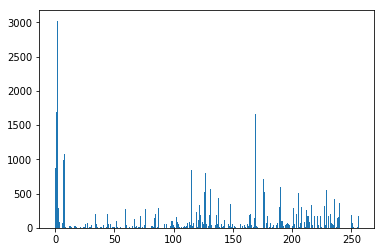

In [103]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [104]:
fs_imp_feat = []
for feat,weight in zip(x_train.columns, fs.scores_):
    if abs(weight) > 1:
        fs_imp_feat.append(feat)
print('There are %d important features' %(len(fs_imp_feat)))

There are 223 important features


In [105]:
x_train_3 = x_train[fs_imp_feat]

feat_box_cox = [i for i in fs_imp_feat if i in to_box_cox]
feat_yeo_j = [i for i in fs_imp_feat if i in to_yeoj]

preprocess = ColumnTransformer(
            transformers = [
                            ('box-cox', PowerTransformer(method='box-cox'), feat_box_cox),
                            ('yeo-j', PowerTransformer(method='yeo-johnson'), feat_yeo_j),
            ], remainder='passthrough'
                            )

**Lasso:**

In [106]:
model = Lasso(random_state=42)
params = {
    'lasso__alpha': loguniform(1e-6, 10)
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
grid_search.fit(x_train_3, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'lasso__alpha': 0.00022567751788824385}
Best Score:  0.11858522972581724


**Ridge:**

In [107]:
model = Ridge()
params = {
    'ridge__alpha': loguniform(1e-6, 10),
    'ridge__solver': ('auto', 'svd', 'cholesky', 'saga')
        }

pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
grid_search.fit(x_train_3, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'ridge__alpha': 7.673614226991978, 'ridge__solver': 'cholesky'}
Best Score:  0.1180818425462436


**XGBRegressor:**

In [108]:
model = XGBRegressor(random_state=41, objective ='reg:squarederror', verbosity=0)
params = {
    'xgbregressor__n_estimators': (1000, 1500, 2000, 25000, 3000),
    'xgbregressor__learning_rate': loguniform(5e-4, 0.5),
    'xgbregressor__gamma': uniform(0.05, 0.5),
    'xgbregressor__reg_alpha': uniform(0.1, 1),
    'xgbregressor__reg_lambda': uniform(0.1, 1),
    'xgbregressor__max_depth': (3, 4)
        }
# pipeline = make_pipeline(preprocess, model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train_3, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'xgbregressor__gamma': 0.1009453491763986, 'xgbregressor__learning_rate': 0.012526579470894885, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 1000, 'xgbregressor__reg_alpha': 0.7588036210260883, 'xgbregressor__reg_lambda': 0.6174635714797791}

Best Score:  0.13611994569339628

**ElasticNet:**

In [109]:
model = ElasticNet()
params = {
    'elasticnet__alpha': loguniform(1e-5, 10),
    'elasticnet__l1_ratio': uniform(0, 1),
        }
pipeline = make_pipeline(preprocess, RobustScaler(), model)

grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
grid_search.fit(x_train_3, y_train)
print('Best Hyperparameters: %s' %grid_search.best_params_)
print('Best Score: ', -1.0*grid_search.best_score_)

Best Hyperparameters: {'elasticnet__alpha': 0.00040723826086807473, 'elasticnet__l1_ratio': 0.8514267753409143}
Best Score:  0.11855306996211713


**LGBM:**

In [110]:
model = LGBMRegressor(objective='regression', verbosity=-1)
params = {
    'lgbmregressor__learning_rate': uniform(1e-3, 1),
    'lgbmregressor__n_estimators': (500, 600, 700, 800, 1000),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__bagging_fraction': uniform(0, 0.99),
    'lgbmregressor__num_leaves': (25, 31, 40),
    'lgbmregressor__reg_lambda': uniform(1e-7, 1e-3),
    'lgbmregressor__min_sum_hessian_in_leaf': uniform(1e-3, 1),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=30)
# grid_search.fit(x_train_3, y_train)
# print('\n')
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'lgbmregressor__bagging_fraction': 0.06034189808825029, 'lgbmregressor__learning_rate': 0.03192014698207368, 'lgbmregressor__min_sum_hessian_in_leaf': 0.08745660665621446, 'lgbmregressor__n_estimators': 700, 'lgbmregressor__num_leaves': 31, 'lgbmregressor__reg_lambda': 0.00022785578936763008}

Best Score:  0.13080664293646999

**CatBoostRegressor:**

In [111]:
model = CatBoostRegressor(eval_metric='RMSE', verbose=False)
params = {
    'catboostregressor__iterations': (1000, 2000, 3000),
    'catboostregressor__learning_rate': uniform(5e-4, 5e-1),
    'catboostregressor__depth': (4, 6, 10),
    'catboostregressor__l2_leaf_reg': (1, 2, 3, 5, 9),
        }
# pipeline = make_pipeline(model)

# grid_search = RandomizedSearchCV(pipeline, params, scoring=neg_rmse, cv=kf, n_iter=20)
# grid_search.fit(x_train_3, y_train)
# print('Best Hyperparameters: %s' %grid_search.best_params_)
# print('Best Score: ', -1.0*grid_search.best_score_)

*Expected output:*

Best Hyperparameters: {'catboostregressor__depth': 4, 'catboostregressor__iterations': 2000, 'catboostregressor__l2_leaf_reg': 1, 'catboostregressor__learning_rate': 0.04309830749433374}

Best Score:  0.12055602904682879